# 2D, 3D Bbox matching

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:,:3]

def load_kitti_label(label_file):
    with open(label_file) as f:
        lines = f.readlines()

    name = []
    truncated = []
    occluded = []
    alpha = []
    bbox = []
    dimensions = []
    location = []
    rotation_y = []
    difficulty = []
    score = []
    index = []
    idx = 0
    for line in lines:
        line = line.strip().split(' ')
        name.append(line[0])
        truncated.append(float(line[1]))
        occluded.append(float(line[2]))
        alpha.append(float(line[3]))
        bbox.append([float(line[4]), float(line[5]), float(line[6]), float(line[7])])
        dimensions.append([float(line[8]), float(line[9]), float(line[10])])
        location.append([float(line[11]), float(line[12]), float(line[13])])
        rotation_y.append(float(line[14]))
        difficulty.append(0)

        if name != 'DontCare':
            index.append(idx)
            idx += 1
        else:
            index.append(-1)

    name = np.array(name, dtype='<U10')
    truncated = np.array(truncated, dtype=np.float32)
    occluded = np.array(occluded, dtype=np.float32)
    alpha = np.array(alpha, dtype=np.float32)
    bbox = np.array(bbox, dtype=np.float32)
    dimensions = np.array(dimensions, dtype=np.float32)
    location = np.array(location, dtype=np.float32)
    rotation_y = np.array(rotation_y, dtype=np.float32)
    difficulty = np.array(difficulty, dtype=np.float32)
    
    return {'name' : name, 'truncated' : truncated,
            'occluded' : occluded, 'alpha' : alpha,
            'bbox' : bbox, 'dimensions' : dimensions,
            'location' : location, 'rotation_y' : rotation_y,
            'difficulty' : difficulty}

def load_kitti_calib(calib_file):
    if not os.path.exists(calib_file):
        print("calib file not exists!!!!!!")
        return None
    with open(calib_file) as f:
        lines = f.readlines()
        # 원래는 7개까지이지만, txt파일을 보면 마지막에 2 줄이 비어있다. 
        # 마지막 줄바꿈 문자까지 읽어오면 총 8줄이다. 
        # 맨 마지막 빈 줄은 파일의 끝을 의미
        assert (len(lines) == 8)

    # 맨 앞 글자 P0: 를 제외하고 뒤의 숫자만 읽어옴
    # strip()은 개행 문자를 제거하기 위해 사용
    obj = lines[0].strip().split(' ')[1:]
    #P0 = np.zeros((4, 4), dtype=np.float32)
    P0 = np.array(obj, dtype=np.float32).reshape(3, -1)
    #P0[3,3] = 1
    
    obj = lines[1].strip().split(' ')[1:]
    #P1 = np.zeros((4, 4), dtype=np.float32)
    P1 = np.array(obj, dtype=np.float32).reshape(3, -1)
    #P1[3,3] = 1
    
    obj = lines[2].strip().split(' ')[1:]
    #P2 = np.zeros((4, 4), dtype=np.float32)
    P2 = np.array(obj, dtype=np.float32).reshape(3, -1)
    #P2[3,3] = 1
    
    obj = lines[3].strip().split(' ')[1:]
    #P3 = np.zeros((4, 4), dtype=np.float32)
    P3 = np.array(obj, dtype=np.float32).reshape(3, -1)
    #P3[3,3] = 1
    
    obj = lines[4].strip().split(' ')[1:]
    R0_rect = np.zeros((4, 4), dtype=np.float32)
    R0_rect[:3,:3] = np.array(obj, dtype=np.float32).reshape(3, -1)
    R0_rect[3,3] = 1

    obj = lines[5].strip().split(' ')[1:]
    Tr_velo_to_cam = np.zeros((4, 4), dtype=np.float32)
    Tr_velo_to_cam[:3, :] = np.array(obj, dtype=np.float32).reshape(3, -1)
    Tr_velo_to_cam[3,3] = 1

    obj = lines[6].strip().split(' ')[1:]
    Tr_imu_to_velo = np.zeros((4, 4), dtype=np.float32)
    Tr_imu_to_velo[:3, :] = np.array(obj, dtype=np.float32).reshape(3, -1)
    Tr_imu_to_velo[3, 3] = 1

    return {'P0' : P0, 'P1' : P1, 'P2' : P2, 'P3' : P3, 'R0_rect' : R0_rect,
            'Tr_velo_to_cam' : Tr_velo_to_cam, 'Tr_imu_to_velo' : Tr_imu_to_velo}



In [24]:
sample = np.ones((2, 4, 8))
test = np.zeros((2, 3, 8))
sample[:, :3, :] = test
matrix = np.ones((2, 3, 4))
matrix@sample.T

(8, 4, 2)


array([[[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]]])

In [25]:
def Center2Edge(xyz_lidar, hwl, rotation_y_lidar):
    bbox_edges = []
    for i, (h,w,l) in enumerate(hwl):
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet\
                    [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
                    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2], \
                    [0.0, 0.0, 0.0, 0.0, h, h, h, h]])

        yaw = rotation_y_lidar[i]
        rotMat = np.array([[np.cos(yaw), -np.sin(yaw), 0.0], 
                        [np.sin(yaw), np.cos(yaw), 0.0], 
                        [0.0, 0.0, 1.0]])
        
        bbox_edges.append(np.dot(rotMat, trackletBox) + xyz_lidar[i].reshape(-1, 1))
    return bbox_edges

def Cam2ImageBbox(calib, label):
    rect = calib['R0_rect']
    Tr_velo_to_cam = calib['Tr_velo_to_cam']
    rt_mat = np.linalg.inv(rect@Tr_velo_to_cam)
    R_vc = calib['R0_rect']
    T_vc = calib['Tr_velo_to_cam']
    P_ = calib['P2']
    velo2image_matrix = P_@R_vc@T_vc

    xyz_base = label['location']
    xyz_base_shape = xyz_base.shape
    xyz = np.ones((xyz_base_shape[0], xyz_base_shape[1]+1))
    
    xyz[:, :3] = xyz_base
    hwl = label['dimensions']
    rotation_y = label['rotation_y']
    xyz_lidar = xyz @ rt_mat.T
    xyz_lidar = (xyz_lidar / xyz_lidar[:, 3].reshape(-1, 1))
    xyz_lidar = xyz_lidar[:, :3]
    rotation_y_lidar = -rotation_y - np.pi/2
    rotation_y_lidar = rotation_y_lidar - np.floor(rotation_y_lidar/(np.pi*2) + 1/2)*np.pi*2
    
    bbox_edges = Center2Edge(xyz_lidar, hwl, rotation_y_lidar)

    img_bboxes = []
    xyz_lidar_base = np.ones((xyz_lidar.shape[0], xyz_lidar.shape[1]+1))
    xyz_lidar_base[:, :3] = xyz_lidar
    xyz_lidar_base[:, 2] += (hwl[:,0]/2)
    img_centers = velo2image_matrix@xyz_lidar_base.T
    img_centers = (img_centers/img_centers[2, :].reshape(1, -1))[:2, :]
    print(velo2image_matrix.shape)
    for i, bbox_edge in enumerate(bbox_edges):
        bbox_edge_base = np.ones((bbox_edge.shape[0]+1, bbox_edge.shape[1]))
        bbox_edge_base[:3, :] = bbox_edge
        img_bbox = velo2image_matrix@bbox_edge_base
        img_bbox = (img_bbox / img_bbox[2, :].reshape(1, -1))[:2, :]
        img_bboxes.append(img_bbox)

    return img_bboxes, img_centers


def show3DBoxes(image, img_bboxes, img_centers):
    line_order = ([0, 1], [1, 2],[2, 3],[3, 0], [4, 5], [5, 6],
         [6 ,7], [7, 4], [4, 0], [5, 1], [6 ,2], [7, 3])

    for i in img_bboxes:
        for k in line_order:    
            cv2.line(image, (int(i[0][k[0]]), int(i[1][k[0]])), (int(i[0][k[1]]), int(i[1][k[1]])), (255, 0, 0), 2)

    for i in range(img_centers.shape[1]):
        img_center = img_centers[:, i]
        cv2.circle(image, (np.int32(img_center[0]), np.int32(img_center[1])), 8, (0, 0, 255), -1)
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.imshow(image)
    return

def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

def IoUConfusionMatrix(img_bboxes_3d, img_bboxes_2d):
    four_edge_3ds = []
    for bbox_3d in img_bboxes_3d:
        four_edge_3d = [bbox_3d[0, :].min(), bbox_3d[1, :].min(), bbox_3d[0, :].max(), bbox_3d[1, :].max()]
        four_edge_3ds.append(four_edge_3d)
    iou_matrix = np.zeros((img_bboxes_2d.shape[0], img_bboxes_2d.shape[0]))

    for i, bbox1 in enumerate(img_bboxes_2d):
        for j, bbox2 in enumerate(four_edge_3ds):
            iou_matrix[i, j] = IoU(bbox1, bbox2)
    
    return iou_matrix
    
def calCenterDist(img_centers_3d, img_bboxes_2d):
    img_centers_2d = np.array([(img_bboxes_2d[:, 0] + img_bboxes_2d[:, 2])/2, (img_bboxes_2d[:, 1] + img_bboxes_2d[:, 3])/2])
    dist = ((img_centers_2d[0, :]-img_centers_3d[0, :])**2 + (img_centers_2d[1, :]-img_centers_3d[1, :])**2)**0.5
    
    return dist

In [26]:
idx         = 4
idx         = str(idx).zfill(6)
image       = cv2.imread('/opt/ml/kitti_data/training/image_2/'+ idx+'.png')
velo_points = load_from_bin('/opt/ml/kitti_data/training/velodyne/'+idx+'.bin')
calib_path  = '/opt/ml/kitti_data/training/calib/'+idx+'.txt'
labels      = load_kitti_label('/opt/ml/kitti_data/training/label_2/'+idx+'.txt')

calib = load_kitti_calib(calib_path)

(3, 4)
[1.89487124e+00 7.26243838e-01 1.14054830e+03 1.07532592e+03
 6.20014464e+02 1.06436256e+03 1.04799446e+03]


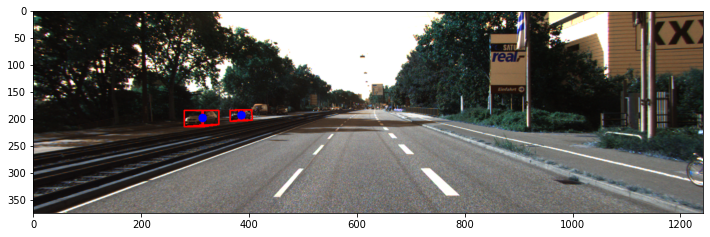

In [27]:
img_bboxes, img_centers = Cam2ImageBbox(calib, labels)
iou_matrix = IoUConfusionMatrix(img_bboxes, labels['bbox'])
dist = calCenterDist(img_centers, labels['bbox'])
image = show3DBoxes(image, img_bboxes, img_centers)
print(dist)

In [26]:
from scipy.optimize import linear_sum_assignment
x, y = linear_sum_assignment(1-iou_matrix)
matched_indices = np.array(list(zip(x,y)))
for m in matched_indices:
    if iou_matrix[m[0], m[1]] > 0.5:
        print(m)    
print(iou_matrix)

[0 0]
[1 1]
[[0.99706725 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.99309643 0.         0.         0.         0.
  0.        ]
 [0.         0.02078228 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
